# Create Track Workbook

The process to create a new DeepRacer Track

1. Start with a track.
1. Edit the center-line waypoints (cut, slices, add)
1. Create a smoothed version.
1. Adjust size
1. Export Numpy and SVG versions

In [19]:
import glob
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import textwrap

In [20]:
def chaikins_corner_cutting(coords, refinements=5):
    _coords = np.array(coords)

    for _ in range(refinements):
        L = _coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        _coords = L * 0.75 + R * 0.25

    return _coords

In [21]:
from shapely.geometry import LineString

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    """
    Plota as coordenadas dos waypoints (linha central, borda interna e externa) diretamente usando Matplotlib.
    """
    # Plota a linha central
    line = LineString(waypoints)
    x, y = line.xy
    ax.plot(x, y, color="orange", linewidth=2, label="Center Line")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos dos waypoints

    # Plota a borda interna
    line = LineString(inner_border_waypoints)
    x, y = line.xy
    ax.plot(x, y, color="blue", linewidth=2, label="Inner Border")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos da borda interna

    # Plota a borda externa
    line = LineString(outer_border_waypoints)
    x, y = line.xy
    ax.plot(x, y, color="green", linewidth=2, label="Outer Border")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos da borda externa

    # Adiciona uma legenda (opcional)
    ax.legend()


## Load the track to work on

In [22]:
# Replace the name here with the track to analyze
TRACK_NAME = '2022_reinvent_champ'
TARGET_TRACK_NAME = 'Inteli'
CENTER_LINE_WIDTH = 25
OUTER_LINE_WIDTH = 25
TRACK_WIDTH = 450
SIZE_ADJUST = -25

In [23]:
# Load the track and waypoints
df_center = pd.read_csv("./LinhaMeio.csv")
df_inner = pd.read_csv("./LinhaInterna.csv")
df_out = pd.read_csv("./LinhaExterna.csv")

center_waypoints = list(zip(df_center['X'], df_center['Y']))
inner_waypoints = list(zip(df_inner['X'], df_inner['Y']))
outer_waypoints = list(zip(df_out['X'], df_out['Y']))


print(f"center {center_waypoints}")
print(f"inner {inner_waypoints}")
print(f"outer {outer_waypoints}")


center [(-21.9839, 15.9216), (-21.7716, 15.9759), (-21.5569, 16.0281), (-21.342, 16.0762), (-21.1291, 16.118), (-20.9203, 16.1515), (-20.7179, 16.1746), (-20.5241, 16.1853), (-20.341, 16.1814), (-20.171, 16.1609), (-20.0161, 16.1217), (-19.8786, 16.0617), (-19.7607, 15.9788), (-19.6165, 15.8494), (-19.4055, 15.6553), (-19.1381, 15.4028), (-18.8249, 15.0981), (-18.4763, 14.7474), (-18.1028, 14.3572), (-17.7149, 13.9335), (-17.3231, 13.4826), (-16.9378, 13.0109), (-16.5696, 12.5246), (-16.2288, 12.0299), (-15.9261, 11.5331), (-15.6534, 11.0425), (-15.3879, 10.5696), (-15.1175, 10.1248), (-14.8303, 9.7188), (-14.5143, 9.3621), (-14.1574, 9.0654), (-13.7477, 8.8392), (-13.2732, 8.6941), (-12.7218, 8.6408), (-12.0816, 8.6897), (-11.3406, 8.8515), (-10.4867, 9.1368), (-9.994, 9.3414), (-9.4376, 9.5985), (-8.8291, 9.899), (-8.18, 10.2337), (-7.5016, 10.5934), (-6.8056, 10.969), (-6.1034, 11.3513), (-5.4064, 11.7311), (-4.7262, 12.0993), (-4.0742, 12.4467), (-3.4619, 12.7642), (-2.9007, 13.042

Is loop/ring?  False
Length: 107.52,108.70,110.07
Width: 0.41


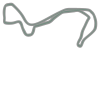

In [24]:
# Convert to Shapely objects
center_line = center_waypoints
inner_border = inner_waypoints
outer_border = outer_waypoints
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
print("Length: {:0.2f},{:0.2f},{:0.2f}".format(l_inner_border.length, l_center_line.length, l_outer_border.length))
print("Width: {:0.2f}".format(l_inner_border.interpolate(0).distance(l_outer_border.interpolate(0))))
road_poly

## Display the original track waypoints

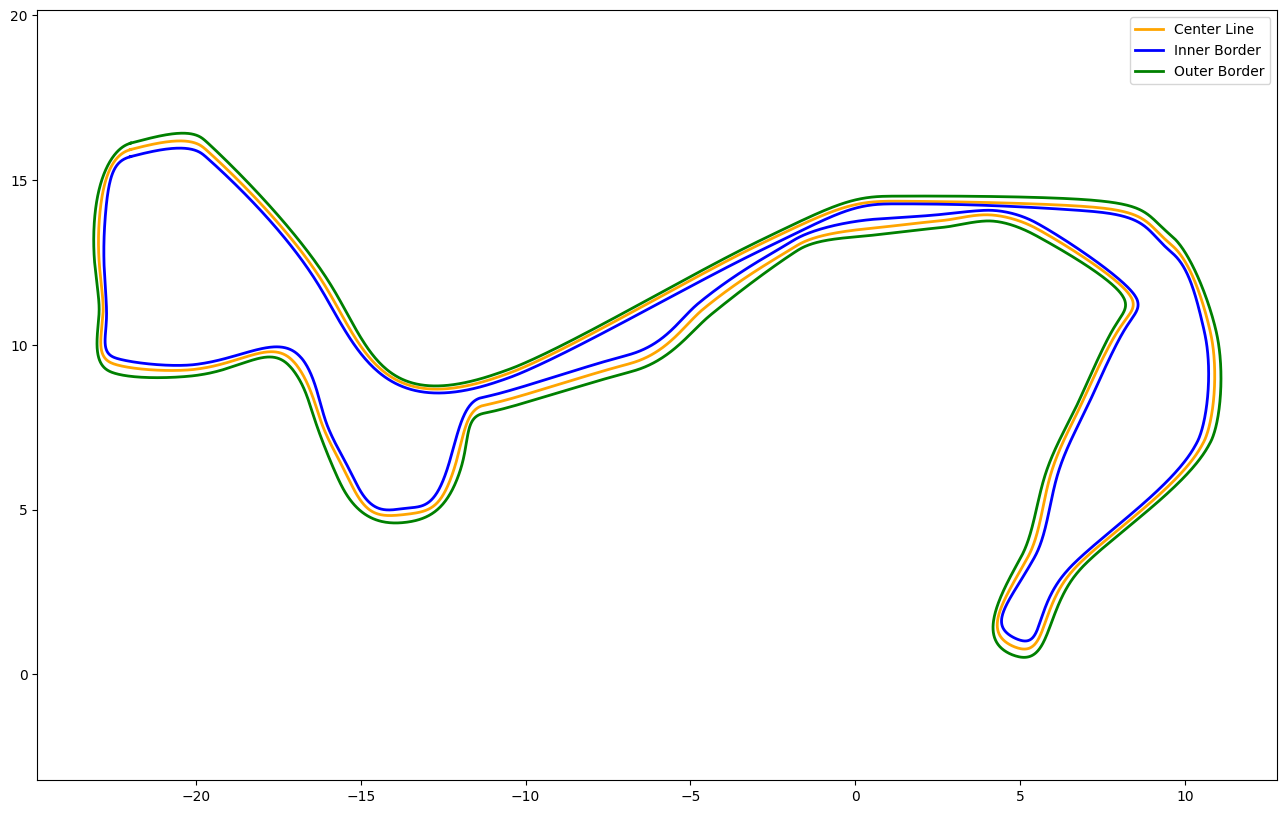

In [26]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')

center_line_loop = np.vstack([center_line, center_line[0]])
inner_line_loop = np.vstack([inner_border, inner_border[0]])
outer_line_loop = np.vstack([outer_border, outer_border[0]])
smooth_center = chaikins_corner_cutting(center_line_loop, refinements=3)
smooth_inner = chaikins_corner_cutting(inner_line_loop, refinements=3)
outer_inner = chaikins_corner_cutting(outer_line_loop, refinements=3)
print_border(ax, smooth_center, smooth_inner, outer_inner)

## Create new Polygons

In [27]:
# Convert into millimeter (needed for SVG) - reduce size of center-line with 10 cm.
center_polygon_reduced = Polygon(smooth_center*1000).buffer(SIZE_ADJUST)

# Normalize position (x and y) 
x_val = np.array(center_polygon_reduced.exterior.xy[0])
x_moved = x_val - min(x_val) + TRACK_WIDTH/2

y_val = np.array(center_polygon_reduced.exterior.xy[1])
y_moved = y_val - min(y_val) + TRACK_WIDTH/2

# Stack into two-column numpy
smooth_center_moved = np.column_stack((x_moved, y_moved))

print(f"smooth_center_moved {smooth_center_moved}")

smooth_center_moved [[ 1178.39392747 15330.05397921]
 [ 1180.68073099 15330.63887526]
 [ 1187.31510599 15332.33575026]
 ...
 [ 1173.67008082 15328.40720452]
 [ 1177.48883082 15329.73845452]
 [ 1178.39392747 15330.05397921]]


In [32]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# Supondo que você já tenha o `smooth_center_moved` definido, vamos criar o polígono
center_polygon_moved_reduced = Polygon(smooth_center_moved)  # Ou substitua se for MultiPolygon

# Filled polygon -- exterior is center-line
center_polygon_moved_reduced = Polygon(smooth_center_moved)

# Polygons for outer line (both inner and outer side)
center_polygon_outer = center_polygon_moved_reduced.buffer(TRACK_WIDTH/3, join_style=1)
center_polygon_outer_border = center_polygon_outer.buffer(-OUTER_LINE_WIDTH, join_style=1)

# Polygons for inner line (both inner and outer side)
center_polygon_inner = center_polygon_moved_reduced.buffer(-TRACK_WIDTH/3, join_style=1)
center_polygon_inner_border = center_polygon_inner.buffer(OUTER_LINE_WIDTH, join_style=1)

# Diff polygons for inner line, outer line and the track surface
inner_border_p = center_polygon_inner_border.difference(center_polygon_inner)
outer_border_p = center_polygon_outer.difference(center_polygon_outer_border)
track_p = center_polygon_outer.difference(center_polygon_inner)

# Start line
start_center_point = center_polygon_moved_reduced.exterior.interpolate(0.0, normalized=True)

print(center_polygon_inner)

start_inner_d = center_polygon_inner.exterior.project(start_center_point, normalized=True)
start_inner_p = center_polygon_inner.exterior.interpolate(start_inner_d, normalized=True)

start_outer_d = center_polygon_outer.exterior.project(start_center_point, normalized=True)
start_outer_p = center_polygon_outer.exterior.interpolate(start_outer_d, normalized=True)

start_line_ls = LineString([start_inner_p, start_outer_p])

POLYGON ((1221.745242365028 15186.313293509564, 1224.4841170002528 15187.013815849143, 1234.4356795002059 15189.559128349132, 1247.7044295002017 15192.95287834913, 1264.2903670002072 15197.195065849131, 1284.193492000202 15202.28569084913, 1307.4138045002014 15208.224753349128, 1333.8242979090146 15214.979768855952, 1360.1454493117635 15221.669934514117, 1386.5045277558916 15228.327799442877, 1412.901533915926 15234.9533613197, 1439.3364684391752 15241.546617822572, 1465.8093319659686 15248.107566635135, 1492.3201251160149 15254.636205443338, 1518.8688484982415 15261.132531937927, 1545.386810808711 15267.579842755844, 1571.8390844026424 15273.947298298452, 1598.2939358490482 15280.251498637308, 1624.7513702596998 15286.492447401502, 1651.2113927963267 15292.670148193922, 1677.6740086501202 15298.784604586068, 1704.1392230594843 15304.835820121838, 1730.6070412928798 15310.823798313208, 1756.996258954735 15316.730365877356, 1783.2714142594086 15322.521855676343, 1809.5128284201785 15328

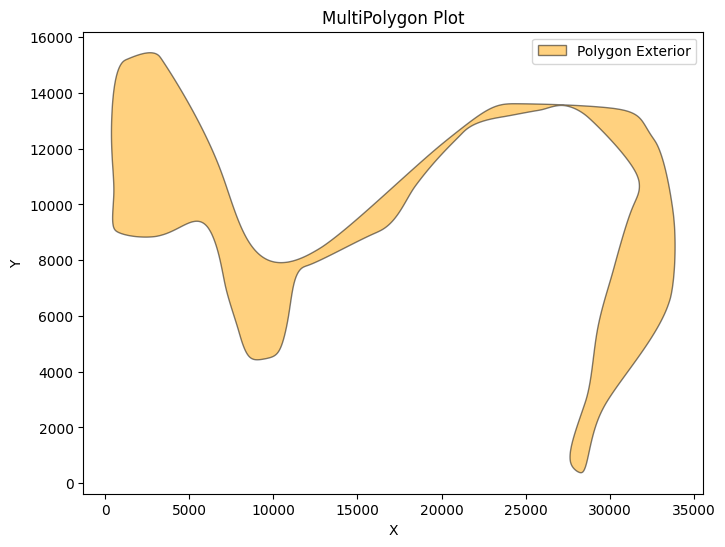

In [33]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry.polygon import orient

def plot_multipolygon(multipolygon, title="MultiPolygon Plot"):
    """
    Plota um MultiPolygon ou Polygon usando matplotlib.
    
    Args:
        multipolygon: Um objeto do tipo MultiPolygon ou Polygon.
        title (str): Título do gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    
    # Verifica se é um MultiPolygon ou apenas um Polygon
    if isinstance(multipolygon, Polygon):
        multipolygon = [multipolygon]  # Transforma em uma lista para padronizar o loop
    
    if isinstance(multipolygon, MultiPolygon):
        polygons = multipolygon.geoms  # Lista de polígonos
    else:
        polygons = multipolygon  # Caso seja uma lista de polígonos
    
    # Plota cada polígono
    for poly in polygons:
        if not poly.is_empty:
            x, y = poly.exterior.xy  # Coordenadas externas
            ax.fill(x, y, alpha=0.5, fc='orange', ec='black', label="Polygon")
            
            # Plota buracos internos, se houver
            for interior in poly.interiors:
                x, y = interior.xy
                ax.plot(x, y, color='red', linestyle='--', label="Hole")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.legend(["Polygon Exterior", "Polygon Hole"], loc="upper right")
    plt.show()
    
plot_multipolygon(center_polygon_inner)

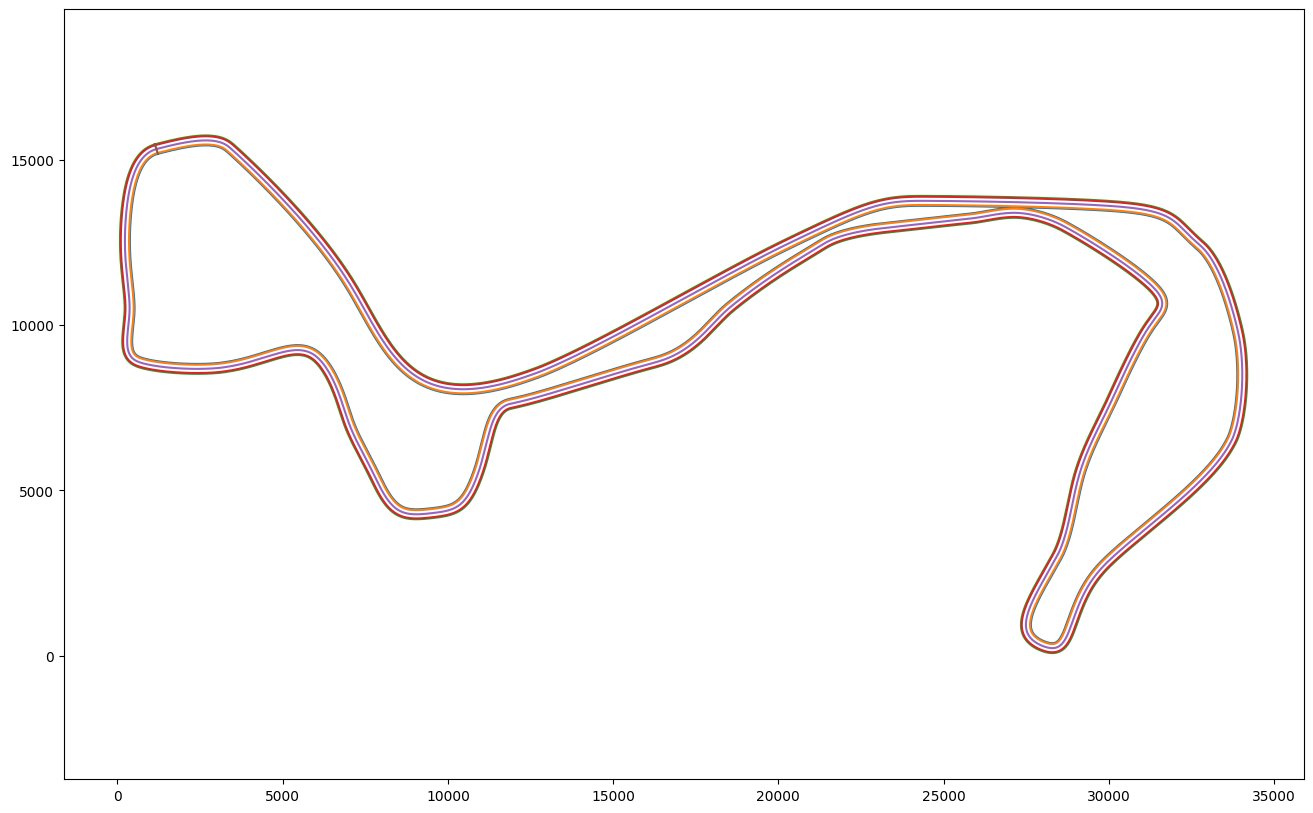

In [34]:
fig = plt.figure(1, figsize=(16, 10))

x_i, y_i = center_polygon_inner.exterior.xy
plt.plot(x_i, y_i)

x_ib, y_ib = center_polygon_inner_border.exterior.xy
plt.plot(x_ib, y_ib)

x_o, y_o = center_polygon_outer.exterior.xy # interna
plt.plot(x_o, y_o)

x_ob, y_ob = center_polygon_outer_border.exterior.xy
plt.plot(x_ob, y_ob)

x, y = center_polygon_moved_reduced.exterior.xy
plt.plot(x,y)

x_s, y_s = start_line_ls.xy
plt.plot(x_s,y_s)

# to net let the image be distorted along the axis
plt.axis('equal')
plt.show()

In [41]:
dim_x = max(x_o)-min(x_o)
dim_y = max(y_o)-min(y_o)
print(f"Track dimensions x:{(dim_x/1000):0.2f}, y:{(dim_y/1000):0.2f}")
print(f"Length: {(center_polygon_outer.exterior.length/1000):0.2f}")

Track dimensions x:34.11, y:15.67
Length: 109.56


## Create waypoints / route for Robomaker

In [42]:
POINTS=100
waypoints_new = np.zeros((POINTS+1,6))
for i in range(0,POINTS):
    p_c = center_polygon_moved_reduced.exterior.interpolate(i/POINTS, normalized=True)
    waypoints_new[i, 0] = p_c.x
    waypoints_new[i, 1] = p_c.y

    d = center_polygon_inner.exterior.project(p_c, normalized=True)
    p = center_polygon_inner.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 2] = p.x
    waypoints_new[i, 3] = p.y

    d = center_polygon_outer.exterior.project(p_c, normalized=True)
    p = center_polygon_outer.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 4] = p.x
    waypoints_new[i, 5] = p.y

waypoints_new[POINTS] = waypoints_new[0]

# Waypoints are in meter (we converted to mm above)
waypoints_new /= 1000.0
np.save(f"../routes/{TARGET_TRACK_NAME}", waypoints_new)

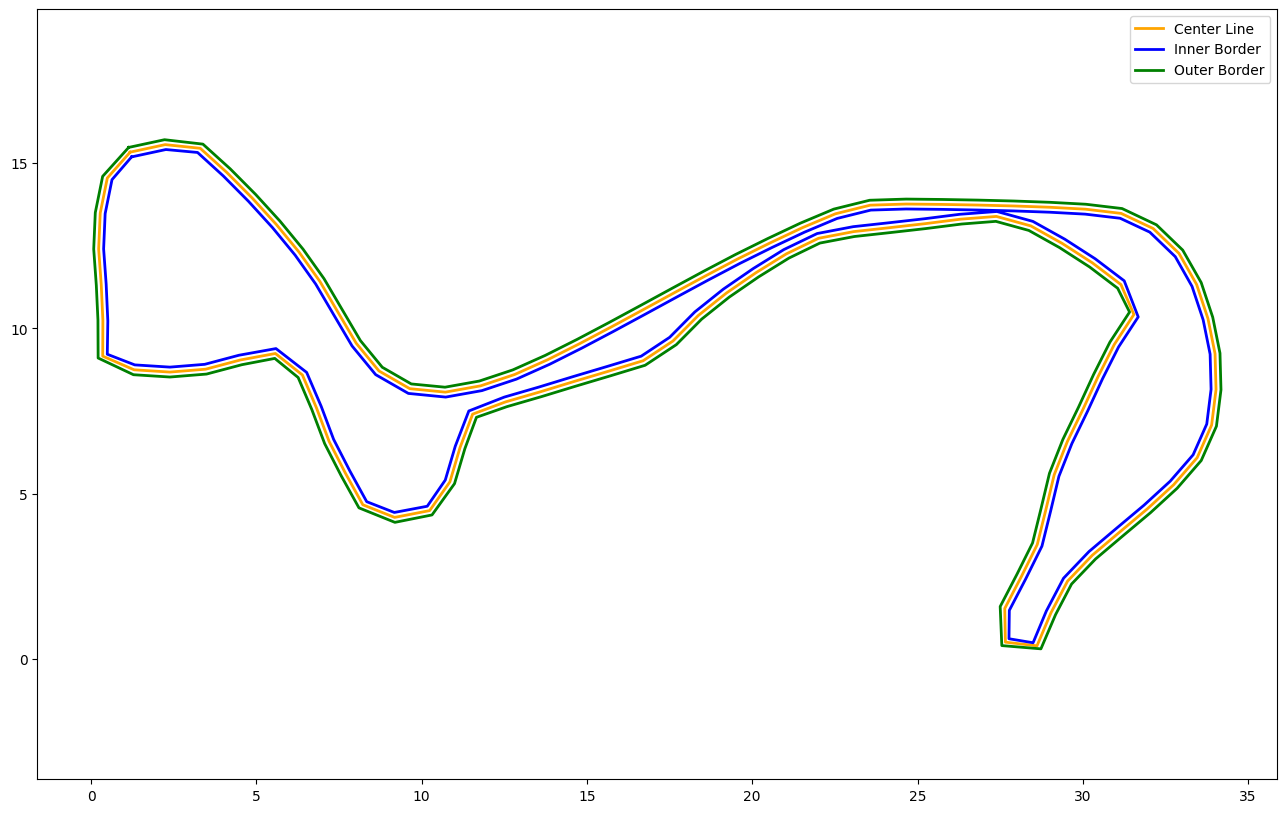

In [43]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')

print_border(ax, waypoints_new[:,0:2], waypoints_new[:,2:4], waypoints_new[:,4:6])

In [50]:
import xml.etree.ElementTree as ET

def create_svg(obj: Polygon, id: str, fill_color: str=None, fill_opacity: float=1, border_color: str=None, border_width: int=0, border_style: str=None, border_offset: int=0):
    tree = ET.ElementTree(ET.fromstring(obj.svg()))
    root = tree.getroot() 
    root.set('id', id)
    
    # Strip not-needed attributes
    root.attrib.pop("fill", None)
    root.attrib.pop("fill-rule", None)
    root.attrib.pop("stroke", None)
    root.attrib.pop("stroke-width", None)
    root.attrib.pop("opacity", None)
    
    style = ""
    
    if fill_color is None:
        style += "fill:none;"
    else:
        style += f"fill:{fill_color};"
        style += f"fill-opacity:{fill_opacity};"

    if border_color is None:
        style += "stroke:none;"
    else:
        style += f"stroke:{border_color};"
        style += f"stroke-width:{border_width};"
        style += "stroke-opacity:1;"

        if border_style is not None:
            style += f"stroke-dasharray:{border_style};"
            style += f"stroke-dashoffset:{border_offset};"

    root.set('style', style)
        
#    return ET.tostring(root, encoding='unicode')
    return root

In [53]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x*1.3, dim_y*1.3),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd',
    'xmlns:inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#00c389',
    'bordercolor': '#000000',
    'borderopacity': '0.25'   
}

with open(f"{TARGET_TRACK_NAME}_raw.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#232f3e", border_color=None))
    svg.insert(2, create_svg(inner_border_p, "il", fill_color="#ffffff", border_color=None))
    svg.insert(3, create_svg(outer_border_p, "ol", fill_color="#ffffff", border_color=None))
    svg.insert(4, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ff9900", border_width=CENTER_LINE_WIDTH, border_style="50,50"))
    svg.insert(5, create_svg(start_line_ls, "start_line", fill_color=None, border_color="#ffffff", border_width=100, border_style=None))

    tree.write(f, encoding='utf-8', xml_declaration=True)


In [54]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x*1.3, dim_y*1.3),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd',
    'xmlns:inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#ffffff',
    'bordercolor': '#000000',
    'borderopacity': '0.25',
    'inkscape:pageopacity': '0',
    'inkscape:pagecheckerboard': 'true'
}

with open(f"{TARGET_TRACK_NAME}_iconography.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#a9a9a9", fill_opacity=0.6, border_color=None))
    svg.insert(2, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ffffff", border_width=50))

    tree.write(f, encoding='utf-8', xml_declaration=True)
